In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install findspark

In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7e3e24646adeb46bb2656792efdd8e8f3810ea0d029ac62350619c5d29497caa
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [8]:
import findspark
from pyspark.sql.functions import *
# findspark.init()
from pyspark.sql import SparkSession
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()
# spark = SparkSession.builder.appName("app_name").getOrCreate()
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df = spark.read.format('csv').option('header', True)\
          .option('inferSchema', True)\
          .option('sep', ',')\
          .load('/content/drive/MyDrive/DATA_ENGINEER/DATABRICKS/AAAA_________IAM___CODING_____Colab Notebooks/Learning/datasset/AFCON/Africa Cup of Nations Players.csv')

df.printSchema()
df.show(10)


root
 |-- _c0: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- ShirtNumber: string (nullable = true)
 |-- PlayerPosition: string (nullable = true)
 |-- PlayerName: string (nullable = true)
 |-- DateofBirth(age): string (nullable = true)
 |-- Caps: string (nullable = true)
 |-- Goals: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- Country: string (nullable = true)

+---+----+-----------+--------------+--------------------+--------------------+----+-----+---------+-------+
|_c0|Year|ShirtNumber|PlayerPosition|          PlayerName|    DateofBirth(age)|Caps|Goals|     Club|Country|
+---+----+-----------+--------------+--------------------+--------------------+----+-----+---------+-------+
|  0|1957|       NULL|            GK|            Ali Bakr|                NULL|NULL| NULL|  Zamalek|  Egypt|
|  1|1957|       NULL|            GK|"Paraskos ""Brasc...|                NULL|NULL| NULL| El-Qanah|  Egypt|
|  2|1957|       NULL|            GK| Abdel-Galil

## Remove space in columns and rows

In [6]:
# Create a list of tuples where the first element is the old column name and the second element is the new column name
rename_columns = [(c, c.strip()) for c in df.columns]

# Use the withColumnRenamed method with a dictionary to rename multiple columns

for current_name, new_name in rename_columns:
    df = df.withColumnRenamed(current_name, new_name)
    df = df.withColumn(new_name, trim(df[new_name]))


# Print the schema of the renamed DataFrame
df.printSchema()
df.show(10)

root
 |-- _c0: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- ShirtNumber: string (nullable = true)
 |-- PlayerPosition: string (nullable = true)
 |-- PlayerName: string (nullable = true)
 |-- DateofBirth(age): string (nullable = true)
 |-- Caps: string (nullable = true)
 |-- Goals: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- Country: string (nullable = true)

+---+----+-----------+--------------+--------------------+--------------------+----+-----+---------+-------+
|_c0|Year|ShirtNumber|PlayerPosition|          PlayerName|    DateofBirth(age)|Caps|Goals|     Club|Country|
+---+----+-----------+--------------+--------------------+--------------------+----+-----+---------+-------+
|  0|1957|       NULL|            GK|            Ali Bakr|                NULL|NULL| NULL|  Zamalek|  Egypt|
|  1|1957|       NULL|            GK|"Paraskos ""Brasc...|                NULL|NULL| NULL| El-Qanah|  Egypt|
|  2|1957|       NULL|            GK| Abdel-Galil H

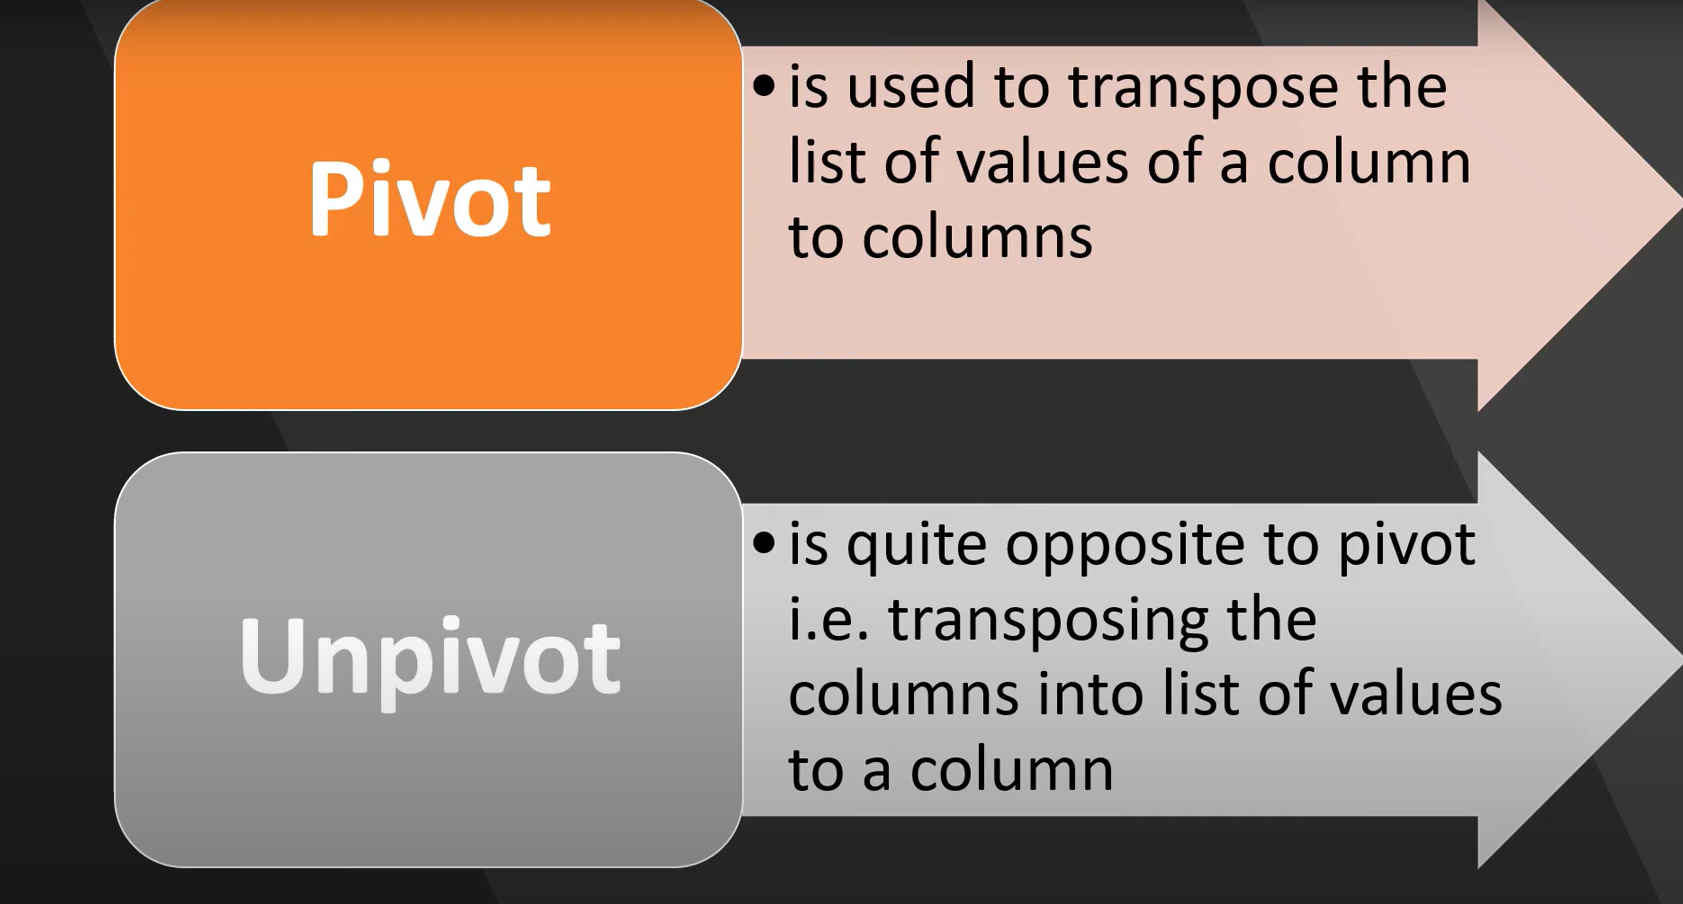

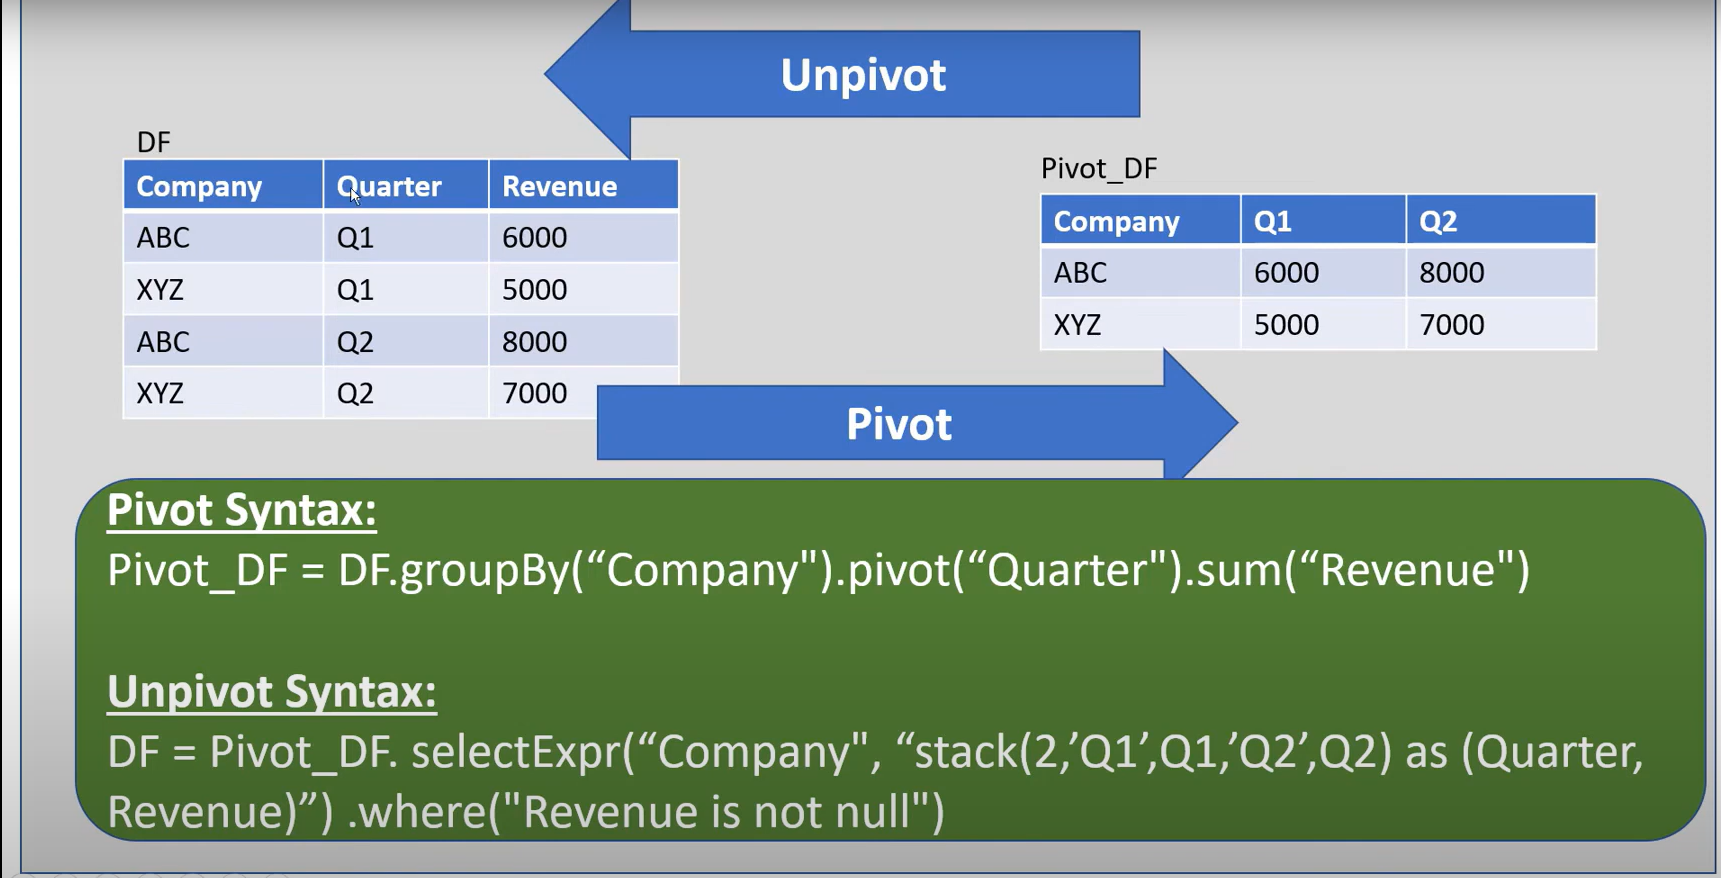

In [31]:
#Create spark session
data = [("Banana",1000,"USA"), ("Carrots",1500,"USA"), ("Beans",1600,"USA"), \
      ("Orange",2000,"USA"),("Orange",2000,"USA"),("Banana",400,"China"), \
      ("Carrots",1200,"China"),("Beans",1500,"China"),("Orange",4000,"China"), \
      ("Banana",2000,"Canada"),("Carrots",2000,"Canada"),("Beans",2000,"Mexico")]

columns= ["Product","Amount","Country"]
df = spark.createDataFrame(data = data, schema = columns)
df.printSchema()
df.orderBy('Product').show(truncate=False)

root
 |-- Product: string (nullable = true)
 |-- Amount: long (nullable = true)
 |-- Country: string (nullable = true)

+-------+------+-------+
|Product|Amount|Country|
+-------+------+-------+
|Banana |2000  |Canada |
|Banana |1000  |USA    |
|Banana |400   |China  |
|Beans  |1500  |China  |
|Beans  |1600  |USA    |
|Beans  |2000  |Mexico |
|Carrots|1500  |USA    |
|Carrots|1200  |China  |
|Carrots|2000  |Canada |
|Orange |2000  |USA    |
|Orange |4000  |China  |
|Orange |2000  |USA    |
+-------+------+-------+



## Pivot DataFrame

*PySpark SQL provides **pivot()** function to rotate the data from one column into multiple columns. It is an aggregation where one of the grouping columns values is transposed into individual columns with distinct data. To get the total amount exported to each country of each product, will do group by Product, pivot by Country, and the sum of Amount.*



In [27]:
pivot_df = df.groupBy('Product').pivot('Country').sum('Amount')
pivot_df.show()

+-------+------+-----+------+----+
|Product|Canada|China|Mexico| USA|
+-------+------+-----+------+----+
| Orange|  NULL| 4000|  NULL|4000|
|  Beans|  NULL| 1500|  2000|1600|
| Banana|  2000|  400|  NULL|1000|
|Carrots|  2000| 1200|  NULL|1500|
+-------+------+-----+------+----+



## Unpivot
Unpivot is a reverse operation, we can achieve by rotating column values into rows values. PySpark SQL doesn’t have unpivot function hence will use the stack() function. Below code converts column countries to row.



In [47]:
unpivotExpr = "stack (4 , 'China',China, 'Canada',Canada,'Mexico',Mexico,'USA',USA) as (Country, Total)"
df_unpivot = pivot_df.select("Product", expr(unpivotExpr)).where('Total is not null')
df_unpivot.orderBy('Product').show()

+-------+-------+-----+
|Product|Country|Total|
+-------+-------+-----+
| Banana|  China|  400|
| Banana| Canada| 2000|
| Banana|    USA| 1000|
|  Beans|  China| 1500|
|  Beans| Mexico| 2000|
|  Beans|    USA| 1600|
|Carrots|  China| 1200|
|Carrots| Canada| 2000|
|Carrots|    USA| 1500|
| Orange|  China| 4000|
| Orange|    USA| 4000|
+-------+-------+-----+

